In [1]:
'''
Building on top of neural_networks_test.ipynb
GET WINDOWS OF 100 CYCLES FROM THE FIRST 160 CYCLES OF EVERY CELL
USE THAT TO BUILD A NEURAL NETWORK USING AN ADVANCED ARCHITECTURE.
'''
import sys
sys.path.insert(0, '/home/viscio/WORK/battery_lifetime')

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
%matplotlib inline

In [4]:
from numpy.random import seed
from tensorflow import set_random_seed
seed(42)
set_random_seed(42)

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
import keras
import keras.backend as kb
from keras import initializers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, ELU, ReLU
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.models import Input, Model
from keras.layers import TimeDistributed
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [8]:
import tensorflow as tf

In [9]:
from utilities import split_df, get_xy, get_xy_scaled, apply_model

In [10]:
# this is used to cache the memory to prevent redoing some 
# heavy computations - mainly weights training
from joblib import Memory
memory = Memory(cachedir='cache')

In [11]:
# Read the data from file
dfs = pd.read_hdf('/home/viscio/WORK/battery_lifetime/data/processed_data/battery_summary_data.h5')

In [12]:
dfs.head()

IR   QCharge  QDischarge       Tavg       Tmax  \
cell_id cycle                                                         
0       1      0.016742  1.071042    1.070689  31.875011  35.652016   
        2      0.016724  1.071674    1.071900  31.931490  35.692978   
        3      0.016681  1.072304    1.072510  31.932603  35.680588   
        4      0.016662  1.072970    1.073174  31.959322  35.728691   
        5      0.016623  1.073491    1.073576  31.961062  35.711758   

                    Tmin  chargetime     RUL            DQ  
cell_id cycle                                               
0       1      29.566130   13.341250  1849.0  0.000000e+00  
        2      29.604385   13.425777  1848.0  4.958155e-07  
        3      29.744202   13.425167  1847.0  1.964282e-06  
        4      29.644709   13.341442  1846.0  2.166772e-06  
        5      29.752932   13.340835  1845.0  4.674332e-06

In [13]:
# Columns to drop
drop_columns = ['RUL', 'chargetime']

In [14]:
# Define R2 metric (1-(SS_res/SS-tot))
# SS_res = sum(y-y_pred)^2
# SS_tot = sum(y-y_mean)^2
def r2_metric(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, np.float32)
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    SS_res = kb.sum(kb.square(y_true - y_pred))
    SS_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return kb.eval((1 - SS_res / (SS_tot + kb.epsilon())))

In [15]:
# Define root mean squared metric
def root_mean_squared_error(y_true, y_pred):
        return kb.sqrt(kb.mean(kb.square(y_pred - y_true))) 

In [16]:
# Number of cycles to use for prediction
n_cycles = 100
#number of features
n_features = dfs.drop(columns=drop_columns).columns.shape[0]

In [17]:
# Let's try to clean the data, since there are a lot of spikes that probably
# represent some error in the sensor reading. 
# We employ Exponential Moving Averages in order to "smoothen out" the problematic curves. 
ir = []
qcharge = []
qdischarge = []
dq = []

for i in dfs.index.levels[0]:
    ewm_ir = dfs.loc[(i, slice(None)),'IR'].ewm(span=5,adjust=False).mean().values
    ewm_qc = dfs.loc[(i, slice(None)),'QCharge'].ewm(span=5,adjust=False).mean().values
    ewm_qd = dfs.loc[(i, slice(None)),'QDischarge'].ewm(span=5,adjust=False).mean().values
    ewm_dq = dfs.loc[(i, slice(None)),'DQ'].ewm(span=5,adjust=False).mean().values
    ir = np.concatenate((ir, ewm_ir), axis=None)
    qcharge = np.concatenate((qcharge, ewm_qc), axis=None)
    qdischarge = np.concatenate((qdischarge, ewm_qd), axis=None)
    dq = np.concatenate((dq, ewm_dq), axis=None)


dfs['IR'] = ir
dfs['QCharge'] = qcharge
dfs['QDischarge'] = qdischarge
dfs['DQ'] = dq

In [18]:
# The idea is to use a RNN to predict what happens at later cycles.
# Get 60 "windows" of 100 cycles from the first 160 cycles as your whole data. 
# Treat this as a number of time-series, each with n_features features (all except RUL)
# The data then needs to be organized as such: (batch_size, timesteps, features)
# and needs to maintain the time-ordering of the sequence. 

X = []
y = []

for i in dfs.index.levels[0]:
    for j in range(61):
        X.append(dfs.loc[(i, slice(j+1,n_cycles+j)), :].drop(columns=drop_columns).values)
        y.append(dfs.loc[(i, n_cycles+j), :].RUL)

X = np.array(X)
y = np.array(y)

print('Input array shape: ', X.shape)

# Split in train/test sets. The data is also randomply selected
# and this is important, since the daa is ordered - by construction.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print('batch size, timesteps, features')
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test ', X_test.shape)
print('y_test ', y_test.shape)

Input array shape:  (7564, 100, 7)
batch size, timesteps, features
X_train (6051, 100, 7)
y_train (6051,)
X_test  (1513, 100, 7)
y_test  (1513,)


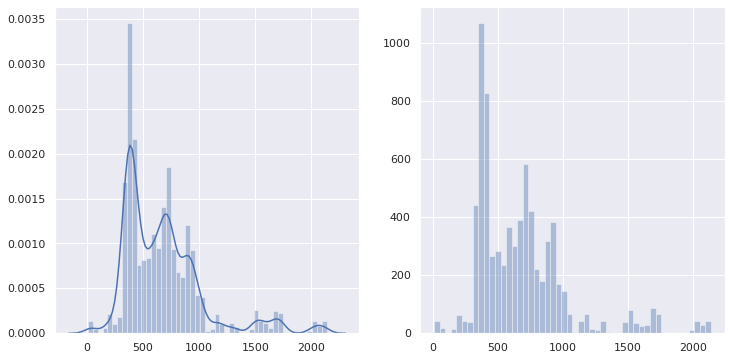

In [19]:
# Getting an idea of the distribution of the RULs in our dataset
sns.set(rc={'figure.figsize':(12,6)})
f = plt.figure()
# Density
ax = f.add_subplot(1, 2, 1)
sns.distplot(y)
ax = f.add_subplot(1, 2, 2)
# Counts
sns.distplot(y, bins=50, kde=False)

In [20]:
n_train_samples = X_train.shape[0]

# number of test entries
n_test_samples = X.shape[0]-X_train.shape[0]

# Scale the data
X_train = X_train.reshape(n_train_samples*n_cycles,n_features)
X_test = X_test.reshape(n_test_samples*n_cycles,n_features)

# Best results with a Min-Max scaler with range [-1, 1]
#scaler = StandardScaler()
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(n_train_samples,n_cycles,n_features)
X_test = X_test.reshape(n_test_samples,n_cycles,n_features)

In [21]:
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences = True, input_shape=(n_cycles, n_features)))
model.add(SimpleRNN(32, activation='relu', return_sequences = True))
model.add(SimpleRNN(16, activation='relu', return_sequences = True))
model.add(SimpleRNN(8, activation='relu', return_sequences = True))
model.add(SimpleRNN(4, activation='relu'))
model.add(Dense(1)) # <---- NOTE: not specifying an activation means that the activation is linear
adam = Adam(learning_rate=0.0005, clipnorm = 0.001)
model.compile(optimizer=adam, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=1000, verbose=1, batch_size = 64, validation_data=(X_test, y_test))


Train on 6051 samples, validate on 1513 samples
Epoch 1/1000
6051/6051 [==============================] - 49s 8ms/step - loss: 442322.0032 - mae: 467.1766 - val_loss: 155237.0506 - val_mae: 262.0640
Epoch 2/1000
6051/6051 [==============================] - 46s 8ms/step - loss: 140033.7335 - mae: 265.1165 - val_loss: 162461.1474 - val_mae: 328.1545
Epoch 3/1000
6051/6051 [==============================] - 48s 8ms/step - loss: 118118.9633 - mae: 241.1676 - val_loss: 105991.1068 - val_mae: 207.8923
Epoch 4/1000
6051/6051 [==============================] - 45s 7ms/step - loss: 105922.7882 - mae: 217.9568 - val_loss: 116374.6999 - val_mae: 258.9196
Epoch 5/1000
6051/6051 [==============================] - 45s 7ms/step - loss: 102358.8564 - mae: 215.7505 - val_loss: 112412.7534 - val_mae: 254.7483
Epoch 6/1000
6051/6051 [==============================] - 50s 8ms/step - loss: 105307.7970 - mae: 219.6967 - val_loss: 120956.0894 - val_mae: 204.9512
Epoch 7/1000
6051/6051 [=====================

6051/6051 [==============================] - 35s 6ms/step - loss: 10971.0730 - mae: 72.3416 - val_loss: 8247.4298 - val_mae: 70.0833
Epoch 55/1000
6051/6051 [==============================] - 18s 3ms/step - loss: 8795.6210 - mae: 65.1159 - val_loss: 12235.7827 - val_mae: 80.8222
Epoch 56/1000
6051/6051 [==============================] - 5s 887us/step - loss: 8277.4290 - mae: 64.2440 - val_loss: 8908.5370 - val_mae: 66.3580
Epoch 57/1000
6051/6051 [==============================] - 5s 836us/step - loss: 9062.2162 - mae: 66.2571 - val_loss: 9504.2558 - val_mae: 66.7671
Epoch 58/1000
6051/6051 [==============================] - 5s 854us/step - loss: 8567.3583 - mae: 64.9054 - val_loss: 8867.3970 - val_mae: 70.8855
Epoch 59/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 7107.1386 - mae: 60.2695 - val_loss: 5492.4417 - val_mae: 52.1398
Epoch 60/1000
6051/6051 [==============================] - 6s 922us/step - loss: 7157.0688 - mae: 58.0444 - val_loss: 5399.0669 - val_

Epoch 110/1000
6051/6051 [==============================] - 5s 885us/step - loss: 3708.8104 - mae: 41.8204 - val_loss: 9118.8918 - val_mae: 75.1397
Epoch 111/1000
6051/6051 [==============================] - 5s 905us/step - loss: 5722.7154 - mae: 50.6895 - val_loss: 4733.1214 - val_mae: 49.9039
Epoch 112/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 5794.5283 - mae: 50.6844 - val_loss: 5848.6050 - val_mae: 58.4620
Epoch 113/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 4118.8340 - mae: 41.5166 - val_loss: 3748.2013 - val_mae: 42.2805
Epoch 114/1000
6051/6051 [==============================] - 5s 806us/step - loss: 3416.6529 - mae: 39.4697 - val_loss: 3208.6014 - val_mae: 42.7700
Epoch 115/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 4565.5838 - mae: 43.8585 - val_loss: 3168.7459 - val_mae: 41.6137
Epoch 116/1000
6051/6051 [==============================] - 5s 891us/step - loss: 3725.0503 - mae: 42.5731 - val_loss:

6051/6051 [==============================] - 5s 802us/step - loss: 3048.9560 - mae: 37.1167 - val_loss: 2465.2114 - val_mae: 36.0833
Epoch 166/1000
6051/6051 [==============================] - 5s 802us/step - loss: 2337.3220 - mae: 32.6825 - val_loss: 1750.5172 - val_mae: 30.3246
Epoch 167/1000
6051/6051 [==============================] - 5s 855us/step - loss: 2050.7904 - mae: 31.8006 - val_loss: 2153.9239 - val_mae: 32.8639
Epoch 168/1000
6051/6051 [==============================] - 5s 818us/step - loss: 2134.2243 - mae: 31.6059 - val_loss: 2217.8111 - val_mae: 33.6634
Epoch 169/1000
6051/6051 [==============================] - 5s 850us/step - loss: 2492.0809 - mae: 34.3623 - val_loss: 1398.9654 - val_mae: 27.4091
Epoch 170/1000
6051/6051 [==============================] - 5s 844us/step - loss: 2235.8407 - mae: 30.8800 - val_loss: 1419.2804 - val_mae: 28.8657
Epoch 171/1000
6051/6051 [==============================] - 5s 824us/step - loss: 2692.3141 - mae: 32.1972 - val_loss: 1743.471

Epoch 221/1000
6051/6051 [==============================] - 5s 891us/step - loss: 3033.2253 - mae: 35.0847 - val_loss: 5095.6723 - val_mae: 46.3884
Epoch 222/1000
6051/6051 [==============================] - 5s 842us/step - loss: 2356.1566 - mae: 31.6126 - val_loss: 2590.1919 - val_mae: 24.4097
Epoch 223/1000
6051/6051 [==============================] - 5s 893us/step - loss: 1247.2251 - mae: 24.2640 - val_loss: 1177.4710 - val_mae: 23.3204
Epoch 224/1000
6051/6051 [==============================] - 5s 841us/step - loss: 2287.3361 - mae: 31.6312 - val_loss: 1529.6964 - val_mae: 28.9347
Epoch 225/1000
6051/6051 [==============================] - 5s 900us/step - loss: 1243.6899 - mae: 24.8907 - val_loss: 846.1245 - val_mae: 21.5623
Epoch 226/1000
6051/6051 [==============================] - 6s 994us/step - loss: 1840.6761 - mae: 26.4348 - val_loss: 1450.7827 - val_mae: 25.4096
Epoch 227/1000
6051/6051 [==============================] - 6s 951us/step - loss: 2203.8764 - mae: 28.7607 - val_

Epoch 277/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 4039.2492 - mae: 36.1279 - val_loss: 575.1417 - val_mae: 17.3457
Epoch 278/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 860.9269 - mae: 21.9214 - val_loss: 735.6501 - val_mae: 17.7972
Epoch 279/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 2275.4455 - mae: 29.8661 - val_loss: 951.8858 - val_mae: 24.8667
Epoch 280/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 1280.1802 - mae: 24.4837 - val_loss: 821.9237 - val_mae: 22.1079
Epoch 281/1000
6051/6051 [==============================] - 10s 2ms/step - loss: 848.1406 - mae: 20.9691 - val_loss: 524.3880 - val_mae: 16.6871
Epoch 282/1000
6051/6051 [==============================] - 9s 1ms/step - loss: 931.9732 - mae: 20.1585 - val_loss: 1027.6079 - val_mae: 21.1216
Epoch 283/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 1254.9043 - mae: 24.8610 - val_loss: 1349.4827

6051/6051 [==============================] - 7s 1ms/step - loss: 687.5672 - mae: 18.5526 - val_loss: 529.3086 - val_mae: 16.1754
Epoch 334/1000
6051/6051 [==============================] - 6s 988us/step - loss: 731.8457 - mae: 18.1658 - val_loss: 1010.8163 - val_mae: 18.9861
Epoch 335/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 1741.4012 - mae: 25.6502 - val_loss: 2847.6850 - val_mae: 28.9368
Epoch 336/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 2659.3246 - mae: 30.1196 - val_loss: 1505.3379 - val_mae: 27.2927
Epoch 337/1000
6051/6051 [==============================] - 6s 985us/step - loss: 939.8218 - mae: 21.0172 - val_loss: 741.0494 - val_mae: 18.6995
Epoch 338/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 690.4925 - mae: 17.9974 - val_loss: 607.6939 - val_mae: 19.1522
Epoch 339/1000
6051/6051 [==============================] - 5s 903us/step - loss: 798.8264 - mae: 19.1016 - val_loss: 4286.9166 - val_mae: 22.

6051/6051 [==============================] - 7s 1ms/step - loss: 1267.8607 - mae: 22.4620 - val_loss: 2117.9627 - val_mae: 23.2785
Epoch 390/1000
6051/6051 [==============================] - 9s 2ms/step - loss: 1375.9209 - mae: 21.2194 - val_loss: 431.4042 - val_mae: 15.0663
Epoch 391/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 943.9404 - mae: 19.6443 - val_loss: 1201.4818 - val_mae: 17.9630
Epoch 392/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 757.8171 - mae: 19.0034 - val_loss: 364.1175 - val_mae: 14.0632
Epoch 393/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 713.7552 - mae: 17.4195 - val_loss: 1314.5137 - val_mae: 20.1534
Epoch 394/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 993.2362 - mae: 21.1812 - val_loss: 1294.3113 - val_mae: 23.5603
Epoch 395/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 1247.3654 - mae: 20.5872 - val_loss: 356.2868 - val_mae: 14.3877


Epoch 446/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 1846.9480 - mae: 25.5817 - val_loss: 504.9300 - val_mae: 16.5093
Epoch 447/1000
6051/6051 [==============================] - 5s 880us/step - loss: 1169.5511 - mae: 22.8339 - val_loss: 6311.0579 - val_mae: 35.8164
Epoch 448/1000
6051/6051 [==============================] - 6s 954us/step - loss: 1531.6708 - mae: 21.0396 - val_loss: 1207.6976 - val_mae: 25.3802
Epoch 449/1000
6051/6051 [==============================] - 6s 931us/step - loss: 1552.8477 - mae: 21.1435 - val_loss: 794.9593 - val_mae: 19.4070
Epoch 450/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 1104.6533 - mae: 18.3099 - val_loss: 623.5883 - val_mae: 14.7644
Epoch 451/1000
6051/6051 [==============================] - 5s 882us/step - loss: 868.7903 - mae: 17.7388 - val_loss: 595.7887 - val_mae: 17.6289
Epoch 452/1000
6051/6051 [==============================] - 6s 958us/step - loss: 948.3745 - mae: 16.4800 - val_loss: 905

6051/6051 [==============================] - 6s 986us/step - loss: 587.0989 - mae: 17.9379 - val_loss: 1035.0686 - val_mae: 26.3715
Epoch 503/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 458.2956 - mae: 15.6582 - val_loss: 745.1797 - val_mae: 22.2866
Epoch 504/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 454.8272 - mae: 15.6821 - val_loss: 425.6876 - val_mae: 15.5145
Epoch 505/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 513.7217 - mae: 15.9471 - val_loss: 262.4468 - val_mae: 12.6132
Epoch 506/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 395.5423 - mae: 14.4218 - val_loss: 991.8150 - val_mae: 23.3940
Epoch 507/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 4223.3068 - mae: 31.7401 - val_loss: 720.8954 - val_mae: 18.1395
Epoch 508/1000
6051/6051 [==============================] - 5s 877us/step - loss: 1655.0924 - mae: 23.9486 - val_loss: 2318.0320 - val_mae: 34.1904

6051/6051 [==============================] - 6s 1ms/step - loss: 1099.3067 - mae: 19.3293 - val_loss: 624.1751 - val_mae: 18.2132
Epoch 559/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 771.6267 - mae: 18.1494 - val_loss: 536.5375 - val_mae: 16.2877
Epoch 560/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 664.5017 - mae: 16.4038 - val_loss: 748.0469 - val_mae: 17.6578
Epoch 561/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 886.8312 - mae: 18.9828 - val_loss: 5684.0105 - val_mae: 39.7657
Epoch 562/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 3202.4844 - mae: 30.7461 - val_loss: 2106.8269 - val_mae: 27.3946
Epoch 563/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 682.2550 - mae: 15.6453 - val_loss: 239.7449 - val_mae: 11.5774
Epoch 564/1000
6051/6051 [==============================] - 11s 2ms/step - loss: 426.3554 - mae: 14.3636 - val_loss: 384.0849 - val_mae: 13.8314
Ep

6051/6051 [==============================] - 6s 978us/step - loss: 11944.9271 - mae: 46.6433 - val_loss: 5061.1487 - val_mae: 42.9016
Epoch 615/1000
6051/6051 [==============================] - 5s 842us/step - loss: 2984.1685 - mae: 31.2126 - val_loss: 943.9369 - val_mae: 16.1486
Epoch 616/1000
6051/6051 [==============================] - 6s 958us/step - loss: 1825.8915 - mae: 21.5959 - val_loss: 810.8819 - val_mae: 14.6261
Epoch 617/1000
6051/6051 [==============================] - 6s 911us/step - loss: 1033.6887 - mae: 17.0192 - val_loss: 963.9154 - val_mae: 19.9663
Epoch 618/1000
6051/6051 [==============================] - 5s 870us/step - loss: 1291.7571 - mae: 19.1506 - val_loss: 705.2855 - val_mae: 14.0936
Epoch 619/1000
6051/6051 [==============================] - 5s 900us/step - loss: 426.3515 - mae: 14.3228 - val_loss: 1126.0733 - val_mae: 22.9628
Epoch 620/1000
6051/6051 [==============================] - 6s 943us/step - loss: 589.3900 - mae: 16.2885 - val_loss: 778.2408 - va

6051/6051 [==============================] - 5s 824us/step - loss: 476.8811 - mae: 14.4483 - val_loss: 207.0611 - val_mae: 10.6209
Epoch 671/1000
6051/6051 [==============================] - 5s 852us/step - loss: 533.9953 - mae: 14.2544 - val_loss: 519.4775 - val_mae: 16.9361
Epoch 672/1000
6051/6051 [==============================] - 5s 799us/step - loss: 539.5580 - mae: 16.4170 - val_loss: 502.1016 - val_mae: 16.4308
Epoch 673/1000
6051/6051 [==============================] - 5s 805us/step - loss: 542.5251 - mae: 16.6654 - val_loss: 268.5154 - val_mae: 12.1032
Epoch 674/1000
6051/6051 [==============================] - 5s 802us/step - loss: 704.4618 - mae: 14.3645 - val_loss: 492.7920 - val_mae: 16.4032
Epoch 675/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 419.9071 - mae: 14.2249 - val_loss: 159.9625 - val_mae: 9.5862
Epoch 676/1000
6051/6051 [==============================] - 6s 923us/step - loss: 640.4703 - mae: 16.7658 - val_loss: 619.5028 - val_mae: 16.7

6051/6051 [==============================] - 7s 1ms/step - loss: 243.6142 - mae: 11.5080 - val_loss: 344.0598 - val_mae: 14.3716
Epoch 727/1000
6051/6051 [==============================] - 6s 925us/step - loss: 387.2076 - mae: 14.6809 - val_loss: 364.3779 - val_mae: 14.8721
Epoch 728/1000
6051/6051 [==============================] - 5s 841us/step - loss: 377.2289 - mae: 12.0991 - val_loss: 211.4774 - val_mae: 10.2326
Epoch 729/1000
6051/6051 [==============================] - 5s 816us/step - loss: 247.6382 - mae: 11.5311 - val_loss: 175.4733 - val_mae: 10.4854
Epoch 730/1000
6051/6051 [==============================] - 5s 839us/step - loss: 236.1138 - mae: 11.0687 - val_loss: 251.7140 - val_mae: 11.4769
Epoch 731/1000
6051/6051 [==============================] - 5s 829us/step - loss: 819.8755 - mae: 15.0951 - val_loss: 1322.4304 - val_mae: 24.0387
Epoch 732/1000
6051/6051 [==============================] - 5s 864us/step - loss: 420.6638 - mae: 13.4856 - val_loss: 280.8626 - val_mae: 12

6051/6051 [==============================] - 8s 1ms/step - loss: 916.3893 - mae: 18.2868 - val_loss: 345.6752 - val_mae: 13.6343
Epoch 783/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 5827.7647 - mae: 29.5916 - val_loss: 9698.2380 - val_mae: 38.1810
Epoch 784/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 9113.5751 - mae: 40.1098 - val_loss: 11944.5879 - val_mae: 47.0201
Epoch 785/1000
6051/6051 [==============================] - 9s 2ms/step - loss: 7988.3824 - mae: 43.0069 - val_loss: 4175.3539 - val_mae: 28.7454
Epoch 786/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 5699.6015 - mae: 35.9089 - val_loss: 5249.0573 - val_mae: 26.4553
Epoch 787/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 8083.5114 - mae: 42.4204 - val_loss: 5036.2918 - val_mae: 31.1757
Epoch 788/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 3158.8105 - mae: 27.2752 - val_loss: 3716.5453 - val_mae: 25

6051/6051 [==============================] - 6s 1ms/step - loss: 548.2614 - mae: 16.1465 - val_loss: 743.3517 - val_mae: 14.6039
Epoch 839/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 542.2421 - mae: 15.8439 - val_loss: 1642.5613 - val_mae: 22.9503
Epoch 840/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 651.5233 - mae: 17.7471 - val_loss: 543.3989 - val_mae: 14.7573
Epoch 841/1000
6051/6051 [==============================] - 8s 1ms/step - loss: 656.7419 - mae: 17.2765 - val_loss: 433.9396 - val_mae: 16.1283
Epoch 842/1000
6051/6051 [==============================] - 7s 1ms/step - loss: 888.1248 - mae: 19.3204 - val_loss: 670.8433 - val_mae: 16.1200
Epoch 843/1000
6051/6051 [==============================] - 6s 988us/step - loss: 551.8657 - mae: 16.9819 - val_loss: 414.3213 - val_mae: 15.0810
Epoch 844/1000
6051/6051 [==============================] - 5s 824us/step - loss: 1105.6701 - mae: 17.8357 - val_loss: 848.2130 - val_mae: 18.4726
E

6051/6051 [==============================] - 5s 894us/step - loss: 1753.7540 - mae: 26.1874 - val_loss: 1827.0996 - val_mae: 28.3478
Epoch 895/1000
6051/6051 [==============================] - 6s 913us/step - loss: 1245.5659 - mae: 22.2817 - val_loss: 2547.3360 - val_mae: 35.4452
Epoch 896/1000
6051/6051 [==============================] - 5s 882us/step - loss: 782.7663 - mae: 18.2466 - val_loss: 447.1199 - val_mae: 15.5010
Epoch 897/1000
6051/6051 [==============================] - 5s 849us/step - loss: 578.7945 - mae: 16.4110 - val_loss: 510.8257 - val_mae: 15.8627
Epoch 898/1000
6051/6051 [==============================] - 5s 867us/step - loss: 584.2796 - mae: 15.8703 - val_loss: 459.2550 - val_mae: 13.8182
Epoch 899/1000
6051/6051 [==============================] - 5s 863us/step - loss: 477.0996 - mae: 15.1869 - val_loss: 493.0879 - val_mae: 16.1548
Epoch 900/1000
6051/6051 [==============================] - 5s 863us/step - loss: 532.0316 - mae: 15.3907 - val_loss: 678.2474 - val_ma

6051/6051 [==============================] - 5s 875us/step - loss: 2350.2557 - mae: 25.4995 - val_loss: 1271.9662 - val_mae: 20.1320
Epoch 951/1000
6051/6051 [==============================] - 6s 935us/step - loss: 1998.0478 - mae: 22.9306 - val_loss: 2384.0584 - val_mae: 24.0174
Epoch 952/1000
6051/6051 [==============================] - 5s 874us/step - loss: 1041.0369 - mae: 19.4837 - val_loss: 1310.2458 - val_mae: 21.3245
Epoch 953/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 1600.8855 - mae: 21.5722 - val_loss: 3785.5184 - val_mae: 32.6252
Epoch 954/1000
6051/6051 [==============================] - 6s 1ms/step - loss: 5546.0110 - mae: 31.9742 - val_loss: 5164.9123 - val_mae: 25.0320
Epoch 955/1000
6051/6051 [==============================] - 6s 923us/step - loss: 2978.7267 - mae: 26.7898 - val_loss: 12436.1514 - val_mae: 40.0543
Epoch 956/1000
6051/6051 [==============================] - 6s 923us/step - loss: 3272.3206 - mae: 28.6403 - val_loss: 4573.3654 -

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100, 64)           4608      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100, 32)           3104      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100, 16)           784       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100, 8)            200       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 8,753
Trainable params: 8,753
Non-trainable params: 0
____________________________________________________

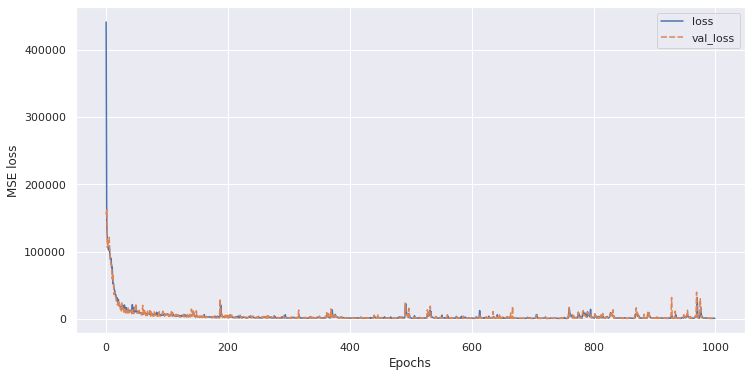

In [23]:
# Graph of the loss function for both train and validation sets
df = pd.DataFrame(history.history['loss'], columns = ['loss'])
df['val_loss'] = history.history['val_loss']

ax = sns.lineplot(data=df)
ax.set(xlabel='Epochs', ylabel='MSE loss')
plt.show()

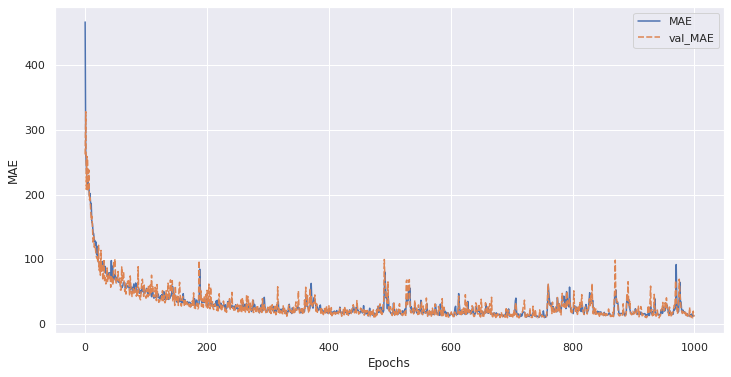

In [24]:
# Graph of the RMSE for both train and validation sets
df = pd.DataFrame(history.history['mae'], columns = ['MAE'])
df['val_MAE'] = history.history['val_mae']

ax = sns.lineplot(data=df)
ax.set(xlabel='Epochs', ylabel='MAE')
plt.show()

In [25]:
scores_train = model.evaluate(X_train, y_train)
scores_test = model.evaluate(X_test, y_test)
print('MSE, MAE train:', scores_train)
print('MSE, MAE test:', scores_test)

1513/1513 [==============================] - 1s 357us/step
MSE, MAE train: [253.46454633600237, 10.1298246383667]
MSE, MAE test: [315.23857409672, 10.602761268615723]


In [26]:
outputs = model.predict(X_test)

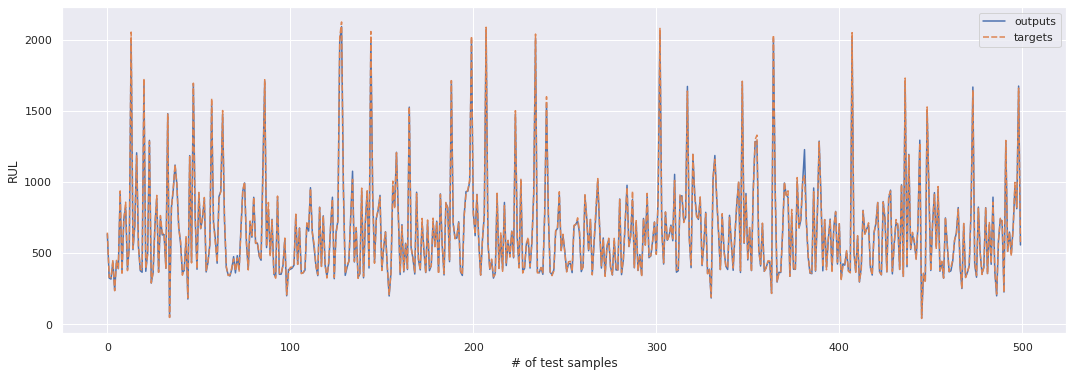

In [27]:
sns.set(rc={'figure.figsize':(18,6)})
df = pd.DataFrame(outputs[0:500], columns = ['outputs'])
df['targets'] = y_test[0:500]
# Graph of the RUL predictions 
ax = sns.lineplot(data=df)
ax.set(xlabel='# of test samples', ylabel='RUL')
plt.show()

In [28]:
# calculate residuals
residuals = [y_test[i]-outputs[i] for i in range(len(outputs))]

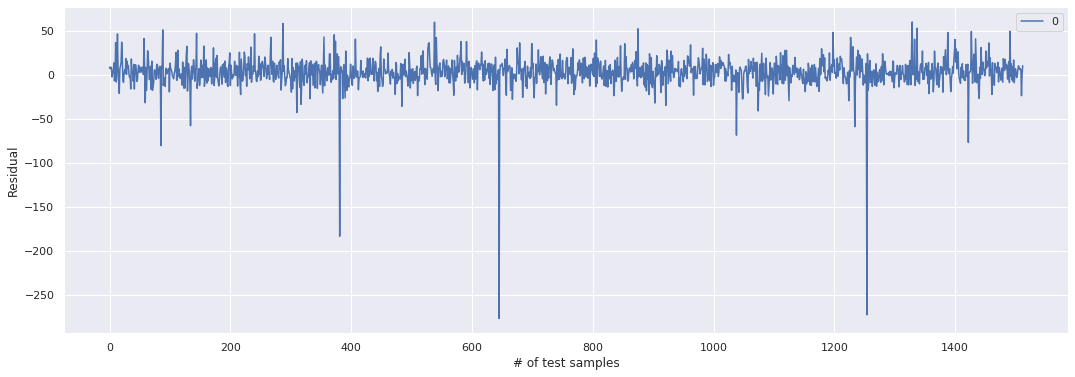

In [29]:
# Plot residuals
residuals = pd.DataFrame(residuals)
ax = sns.lineplot(data=residuals)
ax.set(xlabel='# of test samples', ylabel='Residual')
plt.show()

In [30]:
# summary statistics for residuals
print(residuals.describe())

                 0
count  1513.000000
mean      3.437315
std      17.424813
min    -276.880493
25%      -3.657349
50%       3.755493
75%      10.967987
max      60.454712


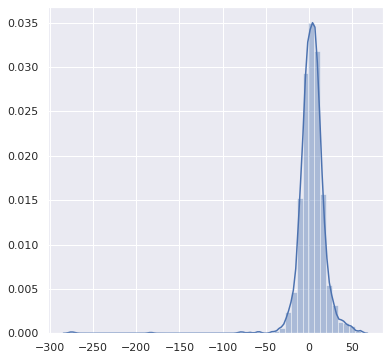

In [31]:
# Plot residuals: check if they are normal-like shaped
sns.set(rc={'figure.figsize':(6,6)})
sns.distplot(residuals, bins=50, kde=True)